In [1]:
%pylab inline
img_rows, img_cols = 28, 28

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [2]:
## to measure time
import time

class Timer():
    def __enter__(self):
        self._t0 = time.perf_counter()
    
    def __exit__(self,type,value,traceback):
        self._t1 = time.perf_counter()
        print("Time spent: [%0.8f] secs" % (self._t1-self._t0))

In [3]:
## libraries for various tasks

import matplotlib.pyplot as plt # for plots
from pprint import pprint # to print matrices in nice ways
from scipy.integrate import simps as quad ## to integrate (but I will not use it)

In [4]:
## it is convenient to vectorize the images
S = 1600
v_train = [x_train[i].reshape(28*28) for i in range(S)]
v_test = [x_test[i].reshape(28*28) for i in range(S)]

In [5]:
## ASSIGNMENT 1

## define d_infty
def _Dinfty(a,b):
    return abs(a-b).max()

## define d_one
def _D1(a,b):
    return abs(a-b).sum()

## define d_two
def _D2(a,b):
    return sqrt(square(a-b).sum())

In [6]:
## ASSIGNMENT 2
## function returning matrix of distances

def my_func(x,N,dist):
    X=x[:N]
    ret = zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            ret[i,j] = dist(X[i],X[j])
    return ret+ret.T

In [7]:
## define distances array and names dictionary

distances = [_D1,_D2,_Dinfty]
names = {_D1:'D1',_D2:'D2',_Dinfty:'D_infty'}

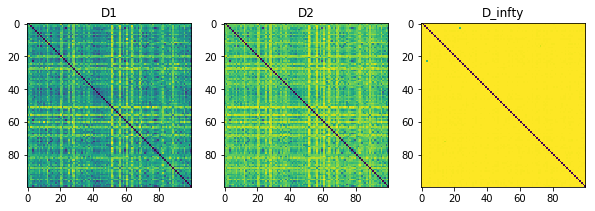

In [8]:
## ASSIGNMENT 3

fig, axs = plt.subplots(1,3,figsize=(10,6))
for ax, distance in zip(axs, distances):
    ax.imshow(my_func(v_train,100,distance),cmap='viridis')
    ax.set_title(names[distance].capitalize())
plt.show()

In [9]:
## ASSIGNMENT 4 and 5
## precompute heavy part of the computation
N = 1600
with Timer():
    M1 = my_func(v_train,N,_D1)
    M2 = my_func(v_train,N,_D2)
    M3 = my_func(v_train,N,_Dinfty)

methods = [M1,M2,M3]

Time spent: [24.62856217] secs


In [10]:
## set difference dimensions to test efficiency
dims = [100,200,400,800,1600]

def efficiency():
    errors = []
    ## computation of the relative errors
    for num in dims:
        loc_errors=[]
        for matrix in methods:
            error_counter = 0.
            for i in range(num):
                M = matrix[i:i+1][0][:num]
                MM = delete(M,i)
                arg = argmin(MM) + int(argmin(MM)>=i)
                digit = y_train[arg]
                if y_train[i] != digit:
                    error_counter +=1
            loc_errors.append(error_counter*100/num)
        errors.append(loc_errors)
    for k in range(size(distances)):
        plt.plot(dims,[errors[i][k] for i in range(size(dims)) ],label=names[distances[k]])
    plt.legend()
    plt.xlabel('slice dimesnion')
    plt.ylabel('percentage error')
    plt.title('Compare different norms')
    plt.show()
    return errors

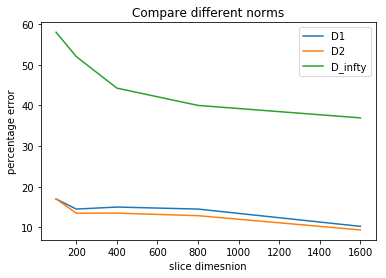

[[17.0, 17.0, 58.0],
 [14.5, 13.5, 52.0],
 [15.0, 13.5, 44.25],
 [14.5, 12.875, 40.0],
 [10.25, 9.375, 36.9375]]


In [11]:
errors = efficiency()
pprint(errors)

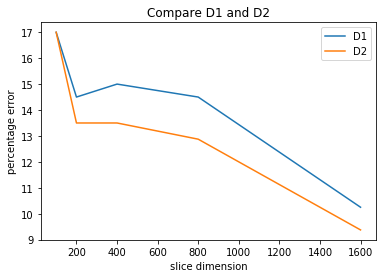

In [12]:
## Focus on the difference between D1 and D2

plt.plot(dims,[errors[i][0] for i in range(size(dims))],label='D1')
plt.plot(dims,[errors[i][1] for i in range(size(dims))],label='D2')

plt.legend()
plt.title('Compare D1 and D2')

plt.xlabel('slice dimension')
plt.ylabel('percentage error')

plt.show()

In [15]:
## define the classify function for later usage
def classify(z,dist,X):
    all_distances = [dist(z,x) for x in X]
    digit = y_train[argmin(all_distances)]
    return digit

(0, 6)

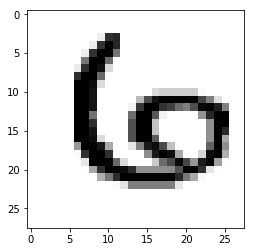

In [16]:
## Example
## scooped!
p = 54
_=imshow(x_test[p], cmap='gray_r')
classify(v_test[p],_D2,v_train[:1000]), y_test[p]

In [17]:
## test x_test angainst y_test with the distance D2
## notice that, for consistency, if you test x_train vs y_train
## then you should get 0.000 errors with any norm: try it!

## my_test function

test_range = 1000

def my_test(X,Y,dist,Z):
    errors = 0.
    for i in range(test_range):
        candidate = classify(X[i],dist,Z)
        if candidate != Y[i]:
            errors += 1
    errors = errors*100/test_range
    print("percentage error: %0.5f" % errors)

In [18]:
with Timer():
    my_test(v_test[:test_range],y_test[:test_range],_D2,v_train[:test_range])

percentage error: 17.20000
Time spent: [6.22789384] secs


In [19]:
## ASSIGNMENT 6

## given the typical structure of our figures, namely
## 1. that points are equally spaced in x and y direction
## 2. that boundary points are zero
## the integral by trapezoids is equal to the sum of the matrix!
## therefore I implement my_trapz, which is extremely fast :)

def my_quad(obj):
    return obj.sum()

In [20]:
## compute all the integrals
S = 1600 
X = x_train[:S]
Y = y_train[:S]

#integrals = [ quad(quad(X[i])) for i in range(1600) ]
integrals = [ my_quad(X[i]) for i in range(S) ]

## compute the new set of train ...
z_train = [X[i]/integrals[i] for i in range(S)]
v2_train = [z_train[i].reshape(28*28) for i in range(S)]

## and their gradients ...
gradients = [gradient(z_train[i]) for i in range(S)]

## finally, construct a collection of big images, containing also the components of the gradients
xd_train=[append([z_train[i].reshape(28*28),gradients[i][0].reshape(28*28)],gradients[i][1].reshape(28*28)) for i in range(S)]

In [21]:
## define new distances

## notice that I do not sqrt in H1
def _Dh1(a,b):
    return _D2(a,b)

## this is my_distance
## which is just D1, but with z_train instead of x_train ;)
def my_dist(a,b):
    return _D1(a,b)

In [22]:
with Timer():
    M4 = my_func(xd_train,S,_Dh1)
with Timer():
    M5 = my_func(v2_train,S,my_dist)

Time spent: [11.31783774] secs
Time spent: [7.05963251] secs


In [23]:
## update data for efficiency comparison
methods = [M2,M4,M5]
distances=[_D2,_Dh1,my_dist]
names[_Dh1]='H1'
names[my_dist]='my_dist'

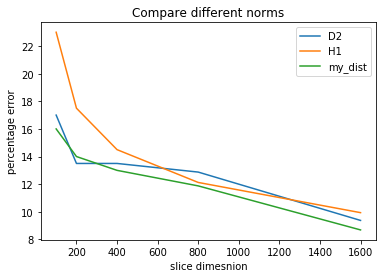

[[17.0, 23.0, 16.0],
 [13.5, 17.5, 14.0],
 [13.5, 14.5, 13.0],
 [12.875, 12.125, 11.875],
 [9.375, 9.9375, 8.6875]]


In [24]:
errors3=efficiency()
pprint(errors3)

In [25]:
## create objects to test new distances
integrals = [ my_quad(x_test[i]) for i in range(test_range) ]

## compute the new set of train ...
z_test = [x_test[i]/integrals[i] for i in range(test_range)]
v2_test = [z_test[i].reshape(28*28) for i in range(test_range)]

## and their gradients ...
gradients = [gradient(z_test[i]) for i in range(test_range)]

## finally, construct a collection of big images, containing also the components of the gradients
xd_test=[append([z_test[i].reshape(28*28),gradients[i][0].reshape(28*28)],gradients[i][1].reshape(28*28)) for i in range(test_range)]

In [26]:
with Timer():
    print('with H1: '), my_test(xd_test[:test_range],y_test[:test_range],_Dh1,xd_train[:test_range])
with Timer():
    print('with my_dist: '), my_test(z_test[:test_range],y_test[:test_range],my_dist,z_train[:test_range])

with H1: 
percentage error: 16.90000
Time spent: [10.02944332] secs
with my_dist: 
percentage error: 16.70000
Time spent: [6.79511325] secs


(0, 6)

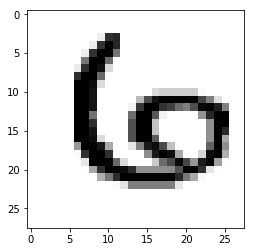

In [55]:
## Example
## scooped!
p = 54
_=imshow(x_test[p], cmap='gray_r')
classify(xd_test[p],_Dh1,xd_train[:1000]), y_test[p]

In [27]:
## ASSIGNMENT 7

## I solve the Laplace equation using Jacobi method

## Define also the discrete Laplacian operator
## which is not explicitely needed, but just in case ...
def Laplacian(obj):
    res = zeros((28,28))
    for i in range(1,27):
        for j in range(1,27):
            res[i][j] = obj[i+1][j]+obj[i-1][j]-4*obj[i][j]+obj[i][j-1]+obj[i][j+1]
    return res

In [28]:
## Alternative method: matricial FE
## Define Jacobi matrix
def Jmatrix(size1):
    size2 = size1*size1

    ## Define the building blocks
    a = ones((size1-1,))
    b = -4*ones((size1,))
    m = (diag(a, -1) + diag(b, 0) + diag(a, +1))

    c = zeros((size1,size1))
    for i in range(size1):
        c[i][i]=1

    ## Define the main matrix
    M = np.zeros((size2,size2))
    for d in range(size1):
        M[d*size1:d*size1+size1, d*size1:d*size1+size1] = m
    for d in range(size1-1):
        M[d*size1:d*size1+size1, d*size1+size1:d*size1+2*size1] = c
    for d in range(1,size1):
        M[d*size1:d*size1+size1, d*size1-size1:d*size1] = c
        
    ## reinitialize boundary elements of M
    for i in range(size1):
        M[i,:],M[:,i] = 0,0
        M[i,i] = 1
        M[-1-i,:],M[:,-1-i] = 0,0
        M[-1-i,-1-i] = 1
    for i in range(1,size1-1):
        M[i*size1,:], M[:,i*size1] = 0,0
        M[i*size1+size1,:], M[i*size1+size1,:] = 0,0
        M[i*size1,i*size1] = 1
        M[i*size1+size1,i*size1+size1] = 1
    return linalg.inv(M)
    #return M
    
J = Jmatrix(28)

## New Laplacian solver (much faster)
def Lsolve(rhs):
    #return linalg.solve(J,rhs.reshape(size2)).reshape(size1,size1)
    return dot(J,rhs.reshape(28*28)).reshape(28,28)

RHS1 = z_train[0]
RHS2 = z_train[9]
with Timer():
    psi1 = Lsolve(RHS1)
    psi2 = Lsolve(RHS2)

Time spent: [0.00337102] secs


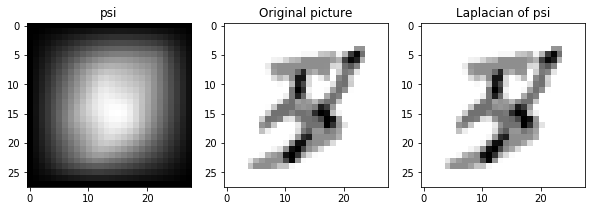

In [29]:
## plot the solution and
## verify the coincidence between
## the Laplacian of psi and original picture

fig, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(psi1+psi2,cmap='gray_r')
axs[1].imshow(RHS1+RHS2,cmap='gray_r')
axs[2].imshow(Laplacian(psi1+psi2),cmap='gray_r')
axs[0].set_title('psi')
axs[1].set_title('Original picture')
axs[2].set_title('Laplacian of psi')
plt.show()

In [30]:
## initialize the set of solutions of the Laplace equation
## but the problem is that my method is very slow... 
with Timer():
    psi_train = [Lsolve(z_train[i]) for i in range(S)]

Time spent: [0.14560328] secs


In [31]:
## Compute the derivatives of psi_train
grad_psi = [gradient(psi_train[i]) for i in range(S)]

## build a larger vectorized object with the gradients
xi_train=[append([z_train[i].reshape(28*28),grad_psi[i][0].reshape(28*28)],grad_psi[i][1].reshape(28*28)) for i in range(S)]

In [74]:
## Define the Morge-Ampere distance
## Notice that, since:
## 1. Laplace's Eq. is linear
## 2. it admits a unique sol
## Then the sol for RHS = a-b
## Coincides with psi_a - psi_b

def _Dma(a,b):
    step = 28*28
    p1 = ((a+b)[:step]).reshape(28,28)
    c = (a - b)[step:3*step]
    p2 = (square(c[0:step])+square(c[step:2*step])).reshape(28,28)
    res = matmul(p1,p2)
    return res.sum()


def _Dma2(a,b):
    step = 28*28
    c = (a - b)
    p1 = abs(c[:step]).reshape(28,28)
    p2 = (square(c[step:2*step])+square(c[2*step:3*step])).reshape(28,28)
    res = matmul(p1,p2)
    return res.sum()

In [75]:
## Notice: since I precomputed psi
## The construnction times for M6/M7
## does not depend on the speed of the Laplace solver

with Timer():
    M6 = my_func(xi_train,S,_Dma)
    M7 = my_func(xi_train,S,_Dma2)

Time spent: [40.08776889] secs


In [76]:
## update data for efficiency comparison
methods = [M2,M5,M6,M7]
distances=[_D2,my_dist,_Dma,_Dma2]
names[_Dma]='MA'
names[_Dma2]='MA2'

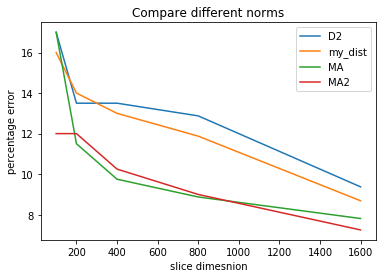

[[17.0, 16.0, 17.0, 12.0],
 [13.5, 14.0, 11.5, 12.0],
 [13.5, 13.0, 9.75, 10.25],
 [12.875, 11.875, 8.875, 9.0],
 [9.375, 8.6875, 7.8125, 7.25]]


In [77]:
errors4=efficiency()
pprint(errors4)

In [78]:
## create objects to test new distances
psi_test = [Lsolve(z_test[i]) for i in range(test_range)]

## and their gradients ...
grad_psi2 = [gradient(psi_test[i]) for i in range(test_range)]

## finally, construct a collection of big images, containing also the components of the gradients
xi_test=[append([z_test[i].reshape(28*28),grad_psi2[i][0].reshape(28*28)],grad_psi2[i][1].reshape(28*28)) for i in range(test_range)]

In [79]:
with Timer():
    print('with MA: '), my_test(xi_test[:test_range],y_test[:test_range],_Dma,xi_train[:test_range])
with Timer():
    print('with MA2: '), my_test(xi_test[:test_range],y_test[:test_range],_Dma2,xi_train[:test_range])

with MA: 
percentage error: 13.20000
Time spent: [15.72025832] secs
with MA2: 
percentage error: 12.60000
Time spent: [17.98928110] secs


(6, 6)

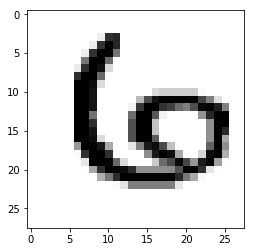

In [80]:
## Example
## scooped!
p = 54
_=imshow(xi_test[p][:28*28].reshape(28,28),cmap='gray_r')
classify(xi_test[p],_Dma,xi_train[:1000]), y_test[p]

## OK, Morge Ampere is really powerful :)

In [56]:
from sklearn.neighbors import *
## Assignment 8 ???
v_train = [ x_train[i].reshape(28*28) for i in range(100)]
tree = BallTree(v_train[:100],metric = _D2)